In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import copy


# Code

In [6]:
class Module:
    def forward(self, x):
        pass

    def backward(self, grad):
        pass

    def update(self, lr):
        pass

class Linear(Module):
    def __init__(self, in_dim, out_dim):
        self.in_dim = in_dim
        xavier = 1 / np.sqrt(in_dim)
        self.W = np.random.uniform(-xavier, xavier, size=(in_dim, out_dim))
        self.b = np.zeros((1, out_dim))
        self.dW = None
        self.db = None
        self.x = None

    def forward(self, x):
        assert x.shape[-1] == self.in_dim
        self.x = x.copy()
        return x @ self.W + self.b

    def backward(self, grad):
        self.dW = self.x.T @ grad
        self.db = np.sum(grad, axis=0, keepdims=True)
        grad_ = grad @ self.W.T
        return grad_

    def update(self, lr):
        self.W -= lr * self.dW
        self.b -= lr * self.db


class ReLU(Module):
    def __init__(self):
        self.x = None

    def forward(self, x):
        self.x = x.copy()
        return x * (x >= 0)

    def backward(self, grad):
        return grad * (self.x >= 0)

class MSE(Module):
    def __init__(self):
        self.x = None
        self.y = None
        self.N = None

    def forward(self, x, y):
        self.x = x.copy()
        self.y = y.copy()
        self.N = x.shape[0] * x.shape[1]
        return np.mean((x-y)**2)

    def backward(self):
        return 2 * (self.x - self.y) / self.N    # (batch, 2)


class DataLoader:
    def __init__(self, X, batch_size):
        self.X = X.copy()
        self.N = X.shape[0]
        self.batch_size = batch_size
        self.idx = np.arange(X.shape[0])

    def __len__(self):
        return np.ceil(self.N / self.batch_size).astype(int)

    def shuffle(self):
        self.idx = np.random.permutation(self.N)
        self.X = self.X[self.idx]

    def __iter__(self):
        start, stop = 0, 0
        self.shuffle()
        while start < self.X.shape[0]:
            stop = start + self.batch_size
            yield self.X[start:stop]
            start = stop

def single_pass(model, dataloader, loss_func, lr, optim=True):
    loss_count = 0
    for i, data in enumerate(dataloader):
        data = data
        pred = model.forward(data)
        loss = loss_func.forward(pred, data)
        loss_count += loss
        grad = loss_func.backward()

        if optim:
            model.backward(grad)
            model.update(lr)
    return loss_count / len(dataloader)



def train_model(model, loss, lr, epochs, dataloaders, print_step=10):
    dataloader_train, dataloader_val = dataloaders
    train_loss_all, val_loss_all = [], []
    # training loop
    for epoch in range(epochs):
        # train
        train_loss = single_pass(model, dataloader_train, loss, lr)
        # validation
        if epoch % print_step == 0:
            val_loss = single_pass(model, dataloader_val, loss, lr, optim=False)
            print(
                f'epoch {epoch}, train_loss={train_loss}, val_loss={val_loss}')

            train_loss_all.append(train_loss)
            # val_loss_all.append(val_loss)

    return train_loss_all, val_loss_all

def create_data(n, noise=False, sigma=0.1):
    # creade set of points at circle with R=1
    phi = 2 * np.pi * np.arange(n) / n    # np.random.rand(n) # np.arange(n) / n
    x, y = np.cos(phi), np.sin(phi)
    if noise:
        x += np.random.normal(0, sigma, n)
        y += np.random.normal(0, sigma, n)
    data = np.hstack((x.reshape(-1, 1), y.reshape(-1, 1)))
    return data



### model

In [7]:
class AutoEncoder(Module):
    def __init__(self, h=6):
        self.encoder = [
            Linear(2, h),
            ReLU(),
            Linear(h, h),
            ReLU(),
            Linear(h, 1),
            ReLU()
        ]
        self.decoder = [
            Linear(1, h),
            ReLU(),
            Linear(h, h),
            ReLU(),
            Linear(h, 2),     # (h, 2)
        ]

    def forward(self, x):
        x_ = x.copy()
        for module in self.encoder:
            x_ = module.forward(x_)
        for module in self.decoder:
            x_ = module.forward(x_)
        return x_

    def backward(self, grad):
        grad_ = grad.copy()
        # print('dec')
        # for i, module in enumerate(self.decoder[::-1]):
        for module in self.decoder[::-1]:
            grad_ = module.backward(grad_)
        #     print(i)
        # print('enc')
        for module in self.encoder[::-1]:
            # print(i)
            grad_ = module.backward(grad_)
        return grad_

    def update(self, lr):
        # print('umpdarw')
        for module in self.encoder:
            module.update(lr)
        for module in self.decoder:
            module.update(lr)


### lr = 1e-2, batch = 4, epochs=500

epoch 0, train_loss=0.5001220420887551, val_loss=0.4979126773156428
epoch 10, train_loss=0.25667876156859765, val_loss=0.25213433585641304
epoch 20, train_loss=0.21037297422591827, val_loss=0.20571042281186303
epoch 30, train_loss=0.17294024700834867, val_loss=0.17032247845334642
epoch 40, train_loss=0.1482570602190781, val_loss=0.14387861230198973
epoch 50, train_loss=0.13052725007916618, val_loss=0.12575181925308698
epoch 60, train_loss=0.11651330186924592, val_loss=0.11048882859532988
epoch 70, train_loss=0.10623150383932412, val_loss=0.09552330365162756
epoch 80, train_loss=0.09294057431509677, val_loss=0.13864465028627498
epoch 90, train_loss=0.09067667662185949, val_loss=0.09147696868368296
epoch 100, train_loss=0.08234454637241893, val_loss=0.09080587818529323
epoch 110, train_loss=0.07156984134349635, val_loss=0.05798196108566358
epoch 120, train_loss=0.06298327777831988, val_loss=0.045898527179962796
epoch 130, train_loss=0.048362011386243915, val_loss=0.034907408728649274
epo

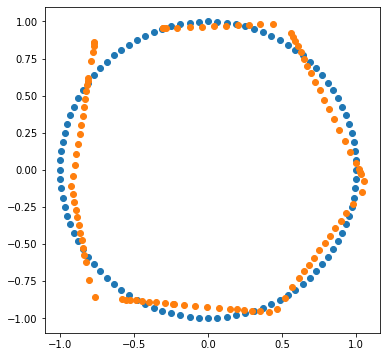

In [13]:
seed=42

random.seed(seed)
np.random.seed(seed)

model = AutoEncoder()

batch_size = 4
epochs = 500
lr = 1e-2
loss = MSE()

# generate data and create dataloaders
data_train = create_data(700)    # 700
data_val = create_data(100)

dataloader_train = DataLoader(data_train, batch_size)
# print(len(dataloader_train))
dataloader_val = DataLoader(data_val, batch_size)
dataloaders = [dataloader_train, dataloader_val]

# train model
train_loss, val_loss = train_model(model, loss, lr, epochs, dataloaders)

# look at examples
data = create_data(100)
pred = model.forward(data)
x, y = data[:, 0], data[:, 1]
x_pred, y_pred = pred[:, 0], pred[:, 1]

plt.figure(figsize=(6, 6))
plt.scatter(x, y, label='true')
plt.scatter(x_pred, y_pred, label='pred')
plt.show()


### lr = 1e-2, batch = 4, epochs=600

epoch 0, train_loss=0.5001220420887551, val_loss=0.4979126773156428
epoch 10, train_loss=0.25667876156859765, val_loss=0.25213433585641304
epoch 20, train_loss=0.21037297422591827, val_loss=0.20571042281186303
epoch 30, train_loss=0.17294024700834867, val_loss=0.17032247845334642
epoch 40, train_loss=0.1482570602190781, val_loss=0.14387861230198973
epoch 50, train_loss=0.13052725007916618, val_loss=0.12575181925308698
epoch 60, train_loss=0.11651330186924592, val_loss=0.11048882859532988
epoch 70, train_loss=0.10623150383932412, val_loss=0.09552330365162756
epoch 80, train_loss=0.09294057431509677, val_loss=0.13864465028627498
epoch 90, train_loss=0.09067667662185949, val_loss=0.09147696868368296
epoch 100, train_loss=0.08234454637241893, val_loss=0.09080587818529323
epoch 110, train_loss=0.07156984134349635, val_loss=0.05798196108566358
epoch 120, train_loss=0.06298327777831988, val_loss=0.045898527179962796
epoch 130, train_loss=0.048362011386243915, val_loss=0.034907408728649274
epo

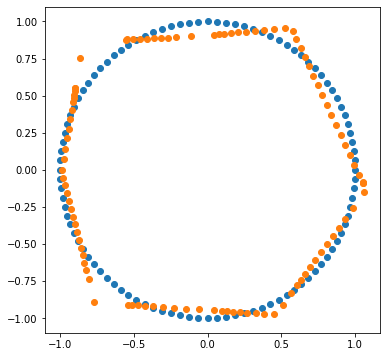

In [20]:
seed=42

random.seed(seed)
np.random.seed(seed)

model = AutoEncoder()

batch_size = 4
epochs = 600
lr = 1e-2
loss = MSE()

# generate data and create dataloaders
data_train = create_data(700)    # 700
data_val = create_data(100)

dataloader_train = DataLoader(data_train, batch_size)
# print(len(dataloader_train))
dataloader_val = DataLoader(data_val, batch_size)
dataloaders = [dataloader_train, dataloader_val]

# train model
train_loss, val_loss = train_model(model, loss, lr, epochs, dataloaders)

# look at examples
data = create_data(100)
pred = model.forward(data)
x, y = data[:, 0], data[:, 1]
x_pred, y_pred = pred[:, 0], pred[:, 1]

plt.figure(figsize=(6, 6))
plt.scatter(x, y, label='true')
plt.scatter(x_pred, y_pred, label='pred')
plt.show()


### lr = 1e-2, batch = 8, epochs=600



epoch 0, train_loss=0.49977693985566723, val_loss=0.4985017167053386
epoch 10, train_loss=0.4778038455382467, val_loss=0.4732444515880537
epoch 20, train_loss=0.25650802484881563, val_loss=0.25222192856724107
epoch 30, train_loss=0.23573460246306316, val_loss=0.23372469169430796
epoch 40, train_loss=0.2102245431793011, val_loss=0.21235991765167972
epoch 50, train_loss=0.1843334542309757, val_loss=0.17918076092907426
epoch 60, train_loss=0.16888104799617587, val_loss=0.16281970123372458
epoch 70, train_loss=0.1575601688362443, val_loss=0.16519251098061655
epoch 80, train_loss=0.14514584407827044, val_loss=0.15356945386061938
epoch 90, train_loss=0.13725352609425803, val_loss=0.14383782409078358
epoch 100, train_loss=0.12855326029892275, val_loss=0.13331055805122624
epoch 110, train_loss=0.11747663402602627, val_loss=0.11484497867573305
epoch 120, train_loss=0.11229882782318672, val_loss=0.11162600488727518
epoch 130, train_loss=0.10495363024400012, val_loss=0.10495778684716596
epoch 140

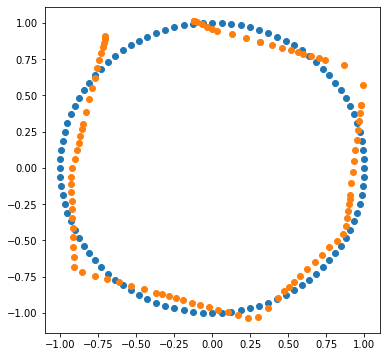

In [27]:
seed=42

random.seed(seed)
np.random.seed(seed)

model = AutoEncoder()

batch_size = 8
epochs = 600
lr = 1e-2
loss = MSE()

# generate data and create dataloaders
data_train = create_data(700)    # 700
data_val = create_data(100)

dataloader_train = DataLoader(data_train, batch_size)
# print(len(dataloader_train))
dataloader_val = DataLoader(data_val, batch_size)
dataloaders = [dataloader_train, dataloader_val]

# train model
train_loss, val_loss = train_model(model, loss, lr, epochs, dataloaders)

# look at examples
data = create_data(100)
pred = model.forward(data)
x, y = data[:, 0], data[:, 1]
x_pred, y_pred = pred[:, 0], pred[:, 1]

plt.figure(figsize=(6, 6))
plt.scatter(x, y, label='true')
plt.scatter(x_pred, y_pred, label='pred')
plt.show()


### lr = 1e-2, batch = 8, epochs=351

epoch 0, train_loss=0.5001220420887551, val_loss=0.4979126773156428
epoch 10, train_loss=0.25667876156859765, val_loss=0.25213433585641304
epoch 20, train_loss=0.21037297422591827, val_loss=0.20571042281186303
epoch 30, train_loss=0.17294024700834867, val_loss=0.17032247845334642
epoch 40, train_loss=0.1482570602190781, val_loss=0.14387861230198973
epoch 50, train_loss=0.13052725007916618, val_loss=0.12575181925308698
epoch 60, train_loss=0.11651330186924592, val_loss=0.11048882859532988
epoch 70, train_loss=0.10623150383932412, val_loss=0.09552330365162756
epoch 80, train_loss=0.09294057431509677, val_loss=0.13864465028627498
epoch 90, train_loss=0.09067667662185949, val_loss=0.09147696868368296
epoch 100, train_loss=0.08234454637241893, val_loss=0.09080587818529323
epoch 110, train_loss=0.07156984134349635, val_loss=0.05798196108566358
epoch 120, train_loss=0.06298327777831988, val_loss=0.045898527179962796
epoch 130, train_loss=0.048362011386243915, val_loss=0.034907408728649274
epo

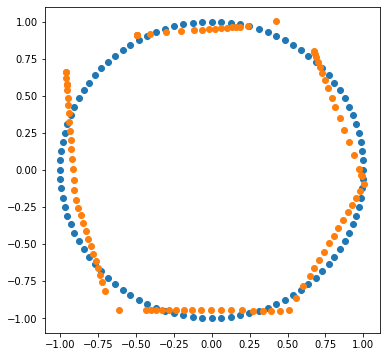

In [26]:
seed=42

random.seed(seed)
np.random.seed(seed)

model = AutoEncoder()

batch_size = 4
epochs = 351
lr = 1e-2
loss = MSE()

# generate data and create dataloaders
data_train = create_data(700)    # 700
data_val = create_data(100)

dataloader_train = DataLoader(data_train, batch_size)
# print(len(dataloader_train))
dataloader_val = DataLoader(data_val, batch_size)
dataloaders = [dataloader_train, dataloader_val]

# train model
train_loss, val_loss = train_model(model, loss, lr, epochs, dataloaders)

# look at examples
data = create_data(100)
pred = model.forward(data)
x, y = data[:, 0], data[:, 1]
x_pred, y_pred = pred[:, 0], pred[:, 1]

plt.figure(figsize=(6, 6))
plt.scatter(x, y, label='true')
plt.scatter(x_pred, y_pred, label='pred')
plt.show()


1. lr = 1e-2, batch = 4, epochs=200
2. lr = 1e-3, batch = 4, epochs=200

epoch 0, train_loss=0.5001220420887551, val_loss=0.4979126773156428
epoch 50, train_loss=0.12881548695309455, val_loss=0.12159742382003794
epoch 100, train_loss=0.0757540676035958, val_loss=0.09273290428619915
epoch 150, train_loss=0.025268063795209707, val_loss=0.02615562062012677


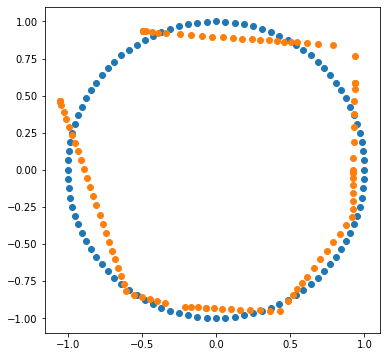

epoch 0, train_loss=0.01494751310018313, val_loss=0.01773765528060966
epoch 10, train_loss=0.015499148874045786, val_loss=0.015243431734665842
epoch 20, train_loss=0.014086528270110586, val_loss=0.007508980021550478
epoch 30, train_loss=0.01387942649969356, val_loss=0.017872978290163825
epoch 40, train_loss=0.013717610183860229, val_loss=0.02336169788814579
epoch 50, train_loss=0.014791439135758944, val_loss=0.018089114119590487
epoch 60, train_loss=0.015366815838156196, val_loss=0.006011711069610428
epoch 70, train_loss=0.015570440463377326, val_loss=0.005715746406479347
epoch 80, train_loss=0.013787476248805348, val_loss=0.00554379798746705
epoch 90, train_loss=0.013736235183286255, val_loss=0.0056780362961399945
epoch 100, train_loss=0.013801224182163683, val_loss=0.005318381904750667
epoch 110, train_loss=0.012171952172792428, val_loss=0.012613011278317422
epoch 120, train_loss=0.013648755942287245, val_loss=0.016054667614670268
epoch 130, train_loss=0.01378992988650868, val_loss=0

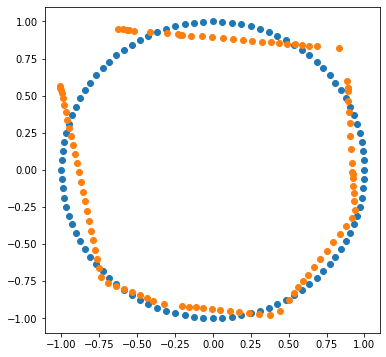

In [30]:
seed=42

random.seed(seed)
np.random.seed(seed)

model = AutoEncoder()

batch_size = 4
epochs = 200
lr = 1e-2
loss = MSE()

# generate data and create dataloaders
data_train = create_data(700)    # 700
data_val = create_data(100)

dataloader_train = DataLoader(data_train, batch_size)
# print(len(dataloader_train))
dataloader_val = DataLoader(data_val, batch_size)
dataloaders = [dataloader_train, dataloader_val]

# train model
train_loss, val_loss = train_model(model, loss, lr, epochs, dataloaders, print_step=50)

# look at examples
data = create_data(100)
pred = model.forward(data)
x, y = data[:, 0], data[:, 1]
x_pred, y_pred = pred[:, 0], pred[:, 1]

plt.figure(figsize=(6, 6))
plt.scatter(x, y, label='true')
plt.scatter(x_pred, y_pred, label='pred')
plt.show()

######


batch_size = 4
epochs = 200
lr = 1e-3

train_loss, val_loss = train_model(model, loss, lr, epochs, dataloaders)



# look at examples
data = create_data(100)
pred = model.forward(data)
x, y = data[:, 0], data[:, 1]
x_pred, y_pred = pred[:, 0], pred[:, 1]

plt.figure(figsize=(6, 6))
plt.scatter(x, y, label='true')
plt.scatter(x_pred, y_pred, label='pred')
plt.show()


epoch 0, train_loss=0.5001220420887551, val_loss=0.4979126773156428
epoch 10, train_loss=0.25667876156859765, val_loss=0.25213433585641304
epoch 20, train_loss=0.21037297422591827, val_loss=0.20571042281186303
epoch 30, train_loss=0.17294024700834867, val_loss=0.17032247845334642
epoch 40, train_loss=0.1482570602190781, val_loss=0.14387861230198973
epoch 50, train_loss=0.13052725007916618, val_loss=0.12575181925308698
epoch 60, train_loss=0.11651330186924592, val_loss=0.11048882859532988
epoch 70, train_loss=0.10623150383932412, val_loss=0.09552330365162756
epoch 80, train_loss=0.09294057431509677, val_loss=0.13864465028627498
epoch 90, train_loss=0.09067667662185949, val_loss=0.09147696868368296
epoch 100, train_loss=0.08234454637241893, val_loss=0.09080587818529323
epoch 110, train_loss=0.07156984134349635, val_loss=0.05798196108566358
epoch 120, train_loss=0.06298327777831988, val_loss=0.045898527179962796
epoch 130, train_loss=0.048362011386243915, val_loss=0.034907408728649274
epo

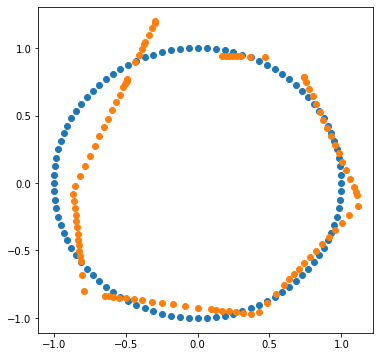

In [22]:
seed=42

random.seed(seed)
np.random.seed(seed)

model = AutoEncoder()

batch_size = 4
epochs = 671
lr = 1e-2
loss = MSE()

# generate data and create dataloaders
data_train = create_data(700)    # 700
data_val = create_data(100)

dataloader_train = DataLoader(data_train, batch_size)
# print(len(dataloader_train))
dataloader_val = DataLoader(data_val, batch_size)
dataloaders = [dataloader_train, dataloader_val]

# train model
train_loss, val_loss = train_model(model, loss, lr, epochs, dataloaders)

# look at examples
data = create_data(100)
pred = model.forward(data)
x, y = data[:, 0], data[:, 1]
x_pred, y_pred = pred[:, 0], pred[:, 1]

plt.figure(figsize=(6, 6))
plt.scatter(x, y, label='true')
plt.scatter(x_pred, y_pred, label='pred')
plt.show()
